In [1]:
from __future__ import division
import os
import urllib, cStringIO
import pymongo as pm ## first establish ssh tunnel to server where database is running
import base64
import numpy as np
from numpy import *
import PIL
from PIL import Image
import base64
import matplotlib
%matplotlib inline
from matplotlib import pylab, mlab, pyplot
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
from matplotlib.path import Path
import matplotlib.patches as patches

import pandas as pd
from svgpathtools import parse_path

#### directory and file hierarchy

In [2]:
# directory & file hierarchy
exp_path = 'museumdraw'
analysis_dir = os.getcwd()
exp_dir = os.path.abspath(os.path.join(os.getcwd(),'../..','experiments'))
##
sketch_dir = os.path.join(analysis_dir,'sketches')
if not os.path.exists(sketch_dir):
    os.makedirs(sketch_dir)
## dir where we can keep all sketches not binned by category    

import sys
## add helpers to python path
if os.path.abspath(os.getcwd()) not in sys.path:
    sys.path.append(os.path.abspath(os.getcwd()))
    
import svg_distance_helpers as rsh
reload(rsh)

<module 'svg_distance_helpers' from 'svg_distance_helpers.pyc'>

In [3]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
coll = db['cdm_run_v3']

#### fetch an example tracing

In [4]:
imrecs = coll.find({'$and':[{'category':'square'},{'dataType':'finalImage'}]}).sort('time')
print imrecs.count()

## retrieve example square tracing from db
imrec = imrecs[90] 

2493


In [5]:
## get list of vertices and codes for tracing 
try:
    ## get the corresponding stroke records for this tracing
    stroke_recs = coll.find({'$and': [{'sessionId':imrec['sessionId']}, 
                                      {'dataType':'stroke'},
                                      {'trialNum': imrec['trialNum']}]}).sort('time')

    print 'Number of strokes in this tracing: {}'.format(stroke_recs.count())    
    
    ## check to make sure that there is at least one stroke! 
    if stroke_recs.count()>0:

        ## now make an svg list!
        svg_list = rsh.make_svg_list(stroke_recs)

        ## now get me some verts and codes!
        __Verts, __Codes = rsh.get_verts_and_codes(svg_list)
        
except Exception as e:
    print 'Oops, something went wrong! Here is the error:'  
    print e
    pass        

Number of strokes in this tracing: 1


#### preprocessing of tracing and visualization (if desired)

In [22]:
## simplify tracing if it is a jungle of verts/horiz commands
reallySimplify = 1
if reallySimplify:
    _Verts,_Codes = rsh.simplify_verts_and_codes(__Verts,__Codes)
else:
    _Verts = np.array(__Verts[0])
    _Codes = __Codes[0]

In [23]:
## make sure the last vertex of the tracing 
## is equal to the first vertex so the
## polygon centroid formula works
if np.sum(_Verts[0][-1] - _Verts[0][0]) != 0:
    _Verts = np.vstack((_Verts,_Verts[0]))
    _Codes.append(2)
assert len(_Verts)==len(_Codes)

In [24]:
## examine tracing
reallyRun = 0
if reallyRun:
    rsh.plot_shape(_Verts,_Codes)

In [25]:
## get vertices and codes for reference shape (in this example, a square)
Verts, Codes = rsh.get_nearest_reference_square_to_tracing(_Verts,_Codes)

In [26]:
## examine reference shape (in this example, a square)
reallyRun = 0
if reallyRun:
    rsh.plot_shape(Verts,Codes)

In [27]:
## get centroid of both shapes
ref_cx,ref_cy = rsh.get_centroid_polygon(Verts)
tra_cx,tra_cy = rsh.get_centroid_polygon(_Verts)

ref_centroid = np.array((ref_cx,ref_cy))
tra_centroid = np.array((tra_cx,tra_cy))

In [28]:
## get verts and codes for the reference and tracing
ref_verts = Verts-ref_centroid
ref_codes = Codes
tra_verts = _Verts-tra_centroid
tra_codes = _Codes

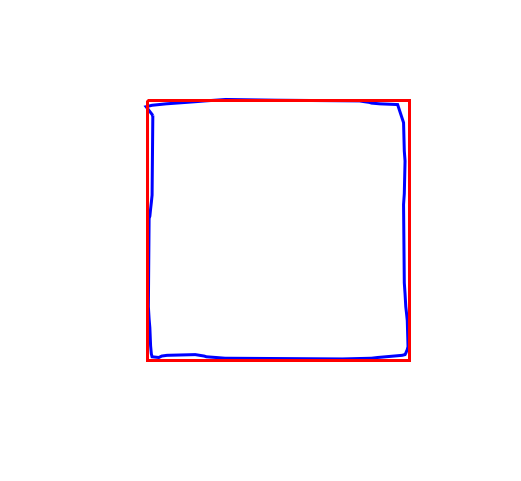

In [29]:
reallyRun = 1
if reallyRun:
    rsh.plot_coregistered_shapes(ref_verts,ref_codes,tra_verts,tra_codes)

##### test case for particular line segment AB on reference shape and point P on tracing (optional, sanity checks)

In [30]:
run_tests = 0
if run_tests:
    ## toy case
    A = np.array((0,0))
    B = np.array((10,10))
    P = np.array((20,5)) ## first point

    ## get point C on A,B that minimizes distance from particular point on tracing to the line segment AB
    C = rsh.get_closest_point_from_P_to_AB(A,B,P,verbose=False) 
    
    ## example real case
    a = ref_verts[0]
    b = ref_verts[1]
    p = tra_verts[1]
    c,d = rsh.get_closest_point_from_P_to_AB(a,b,p,verbose=False) 
    print c,d    

#### get "corresponding points" on the reference shape for each vertex in the tracing

In [31]:
## cor_verts will be the same shape as the tra_verts, and lie on the reference shape
## error will be computed as area between these two shapes
cor_verts = np.zeros((np.shape(tra_verts)[0],2))
for i,t in enumerate(tra_verts): ## loop through segments of the tracing
    p = t ## endpoint of the current tracing segment
    ## for a given point on the tracing, find the corresponding closest point on the reference shape
    ref_gen = rsh.pairs(ref_verts)
    D = 1e6 ## initialize at some crazy large value
    for r in ref_gen:
        a = r[0]
        b = r[1]
        c,d = rsh.get_closest_point_from_P_to_AB(a,b,p,verbose=False) 
        if d<D: ## if the shortest distance so far, then swap in for the value of D
            D = d
            C = c
        else:
            pass 
    cor_verts[i,:] = C ## assign the closest corresponding point to the "corresponding vertices" array

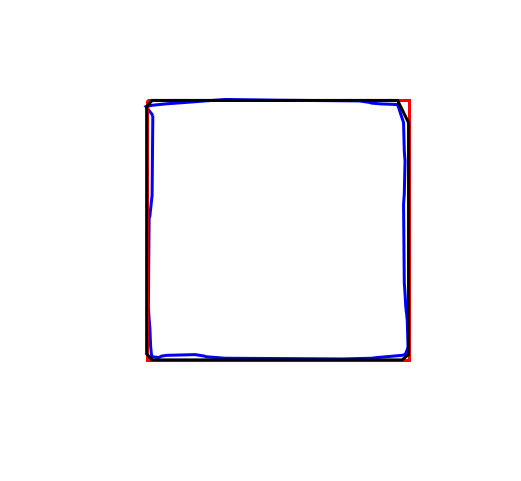

In [32]:
## test to make sure the corresponding points really lie on the reference shape
reload(rsh)
reallyRun = 1
if reallyRun:
    rsh.plot_corresponding_points_on_reference(tra_verts,tra_codes,ref_verts,ref_codes,cor_verts)

#### actually get svg distance error now

In [43]:
## iterate through each pair of line segments comprising the tracing verts
## and corresponding verts, and increment error as area between the line
## segments. 
## When line segments are non-intersecting and non-collinear, safe to use
## general polygon area formula (add the trapezoid)
## If line segments are parallel but not collinear, safe to use
## general polygon area formula (add the trapezoid)
## If line segments intersect, then add the resulting triangles
## formed by the intersecting segments
## If line segments are collinear, do not increment error, b/c perfectly on the line
tracing_to_corresponding_error = rsh.get_area_between_tracing_and_corresponding_verts(tra_verts,cor_verts)

## add to the above the deviation between the area of the reference
## shape and the corresponding shape
cor_area = rsh.get_area_polygon(cor_verts)
ref_area = rsh.get_area_polygon(ref_verts)
corresponding_to_reference_error = abs(abs(ref_area)-abs(cor_area))

In [44]:
## total error is sum of tracing_to_corresponding_error and corresponding_to_reference_error
total_error = tracing_to_corresponding_error + tracing_to_corresponding_error

svg_distance_score = np.sqrt(total_error)
print 'SVG distance score = {}'.format(svg_distance_score)

SVG distance score = 114.121254846
